In [104]:
# Loading required dependencies
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import time

In [105]:
# Define relevant variables for the ML task
batch_size = 256
num_classes = 43
learning_rate = 0.0001
num_epochs = 20

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [106]:
#Loading the dataset and preprocessing
train_dataset = torchvision.datasets.GTSRB(root = './data',
                                           split = 'train',
                                           transform = transforms.Compose([
                                                  transforms.Resize((32,32)),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1307,), std = (0.3081,))]),
                                           download = True)


test_dataset = torchvision.datasets.GTSRB(root = './data',
                                          split = 'test',
                                          transform = transforms.Compose([
                                                  transforms.Resize((32,32)),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1325,), std = (0.3105,))]),
                                          download=True)


train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)


test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

In [107]:
#Defining the convolutional neural network
class LeNet5(nn.Module):
    def __init__(self, num_classes):
        super(LeNet5, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(400, 120)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(120, 84)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(84, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

In [108]:
model = LeNet5(num_classes).to(device)

#Setting the loss function
cost = nn.CrossEntropyLoss()

#Setting the optimizer with the model parameters and learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#this is defined to print how many steps are remaining when training
total_step = len(train_loader)

In [109]:
############ Define the training loop here ###########
device = torch.device("cuda:0" if torch.cuda.is_available() else "gpu")
print("Device: {}".format(device))
model.to(device)
steps_count = len(train_loader)
time_start = time.time()
lst_accuracy = []
lst_steps = []

for ep in range(num_epochs):
    for i, data in enumerate(train_loader):
        images, labels = data[0].to(device), data[1].to(device)

        # Forward Pass
        outputs = model(images)
        loss = cost(outputs, labels)

        # Backpropogation and Optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Train Accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        steps = i + 1

        if (i + 1) % 15 == 0:
            accuracy = (correct / total) * 100
            lst_accuracy.append(accuracy)
            lst_steps.append(steps)
            print(
                "Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%".format(
                    ep + 1, num_epochs, steps, steps_count, loss.item(), accuracy
                )
            )

print(
    "######## Training Finished in {} seconds ###########".format(
        time.time() - time_start
    )
)
print("Accuracy List: ", lst_accuracy, "Steps List: ", lst_steps)


Device: cuda:0
Epoch [1/20], Step [15/105], Loss: 3.6955, Accuracy: 5.86%
Epoch [1/20], Step [30/105], Loss: 3.6388, Accuracy: 7.42%
Epoch [1/20], Step [45/105], Loss: 3.5396, Accuracy: 13.67%
Epoch [1/20], Step [60/105], Loss: 3.5091, Accuracy: 6.64%
Epoch [1/20], Step [75/105], Loss: 3.3926, Accuracy: 7.03%
Epoch [1/20], Step [90/105], Loss: 3.3333, Accuracy: 12.50%
Epoch [1/20], Step [105/105], Loss: 2.9995, Accuracy: 37.50%
Epoch [2/20], Step [15/105], Loss: 3.1454, Accuracy: 18.36%
Epoch [2/20], Step [30/105], Loss: 2.8746, Accuracy: 34.77%
Epoch [2/20], Step [45/105], Loss: 2.7822, Accuracy: 32.42%
Epoch [2/20], Step [60/105], Loss: 2.7106, Accuracy: 39.06%
Epoch [2/20], Step [75/105], Loss: 2.7479, Accuracy: 35.55%
Epoch [2/20], Step [90/105], Loss: 2.5872, Accuracy: 33.20%
Epoch [2/20], Step [105/105], Loss: 2.3666, Accuracy: 43.75%
Epoch [3/20], Step [15/105], Loss: 2.2436, Accuracy: 44.14%
Epoch [3/20], Step [30/105], Loss: 2.2590, Accuracy: 43.36%
Epoch [3/20], Step [45/105]

In [110]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 12609 test images: {} %'.format(100 * correct / total))
	 

Accuracy of the network on the 12609 test images: 85.07521773555028 %


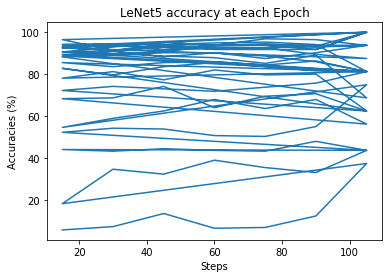

In [111]:
import matplotlib.pyplot as pyplot
import numpy as np

x = np.array(lst_steps)
y = np.array(lst_accuracy)

pyplot.title("LeNet5 accuracy at each Epoch")
pyplot.xlabel("Steps")
pyplot.ylabel("Accuracies (%)")
pyplot.plot(x, y)

pyplot.show()

In [113]:
# Specify a path
PATH = "lenet5_GTSRB.pt"

# Save
torch.save(model, PATH)